In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import time

from scipy.optimize import curve_fit

import warnings

In [2]:
dir        = "DATA/"
file1      = 'BHBH_Delay_Time.csv'

BHBH       = pd.read_csv(dir+file1)

# compute total mass and reduced mass
BHBH[  'Mass_total'] = BHBH.Mass_0 + BHBH.Mass_1
BHBH['Mass_reduced'] = BHBH.Mass_0 * BHBH.Mass_1 / (BHBH.Mass_0 + BHBH.Mass_1)

In [3]:
BHBH.head()

,Unnamed: 0.1,Unnamed: 0,Index,ID,name,BWorldtime,Mass_0,Radius_0,Zams_0,Phase_0,...,Mzams_0,Mzams_1,Semimajor_ini,Eccentricity_ini,Z,alpha,Delay_Time,Eccentricity_Delay,Mass_total,Mass_reduced
0,0,0,0,360308,0_792857804219921,5.411991,18.34303,0.000078,21.22227,7,...,41.0592,34.5745,24.874630,0.2619,0.0004,0.5,9.993410e+04,6.409107e-11,39.43934,9.811783
1,1,1,1,360337,0_285120263308905,4.134819,50.99943,0.000217,92.24360,7,...,92.2436,53.6410,81917.701038,0.3955,0.0004,0.5,5.520443e+16,4.934820e-14,102.77971,25.693444
2,2,2,2,360367,0_303570516402716,4.311590,33.98611,0.000144,41.10912,7,...,74.5563,46.8471,127.422203,0.2217,0.0004,0.5,7.108337e+05,1.981434e-10,64.82397,16.167768
3,3,3,3,360429,0_321152334354104,5.738531,42.61480,0.000181,50.85000,7,...,50.8500,32.3486,316.947946,0.0107,0.0004,0.5,1.214966e+07,2.425785e-12,75.92808,18.697151
4,4,4,4,360471,0_850952161687565,4.503749,49.74939,0.000211,65.22210,7,...,65.2221,46.7855,1548.080290,0.0751,0.0004,0.5,5.995947e+09,1.042263e-11,95.66410,23.877597


Text(0, 0.5, 'Counts')

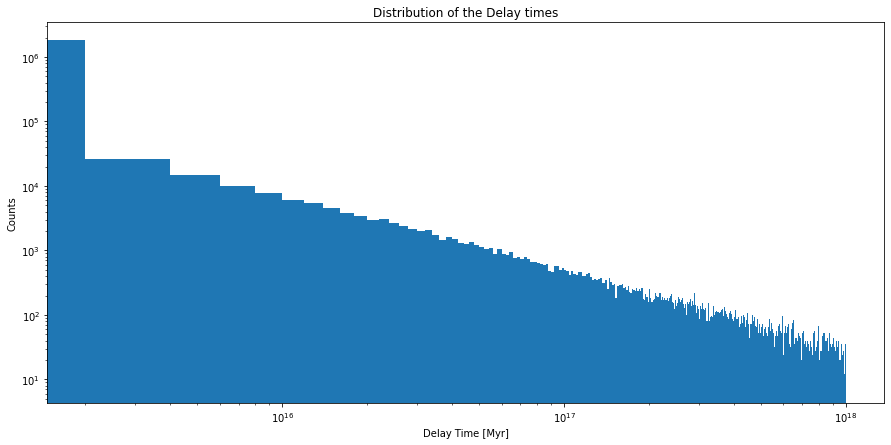

In [78]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='fd')
entries, edges, _ = ax.hist(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins=500)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('Counts')

Text(1.5e+24, 1000.0, '???')

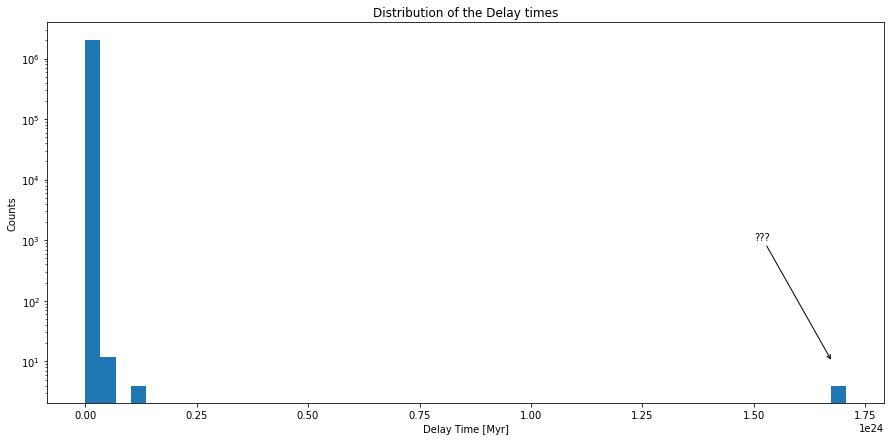

In [80]:
fig, ax = plt.subplots(figsize=(15,7))

ax.hist(BHBH.Delay_Time, bins=50)
#ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('Counts')

ax.annotate( "???", xy = ( 1.675e24, 1e1 ), xytext = ( 1.5e24, 1e3 ),
             arrowprops = dict( arrowstyle = "->" ) )

/home/aidin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


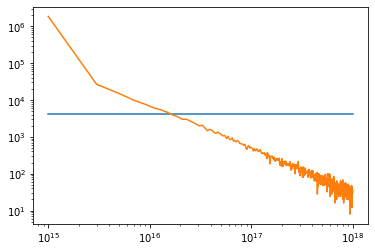

In [77]:
def expo(x, λ):
    return λ * np.exp(-λ*x)

def power_law(x, m, b):
    return x ** m * 10 ** b

popt, pcov = curve_fit(power_law, bin_centers, entries, p0=(1e-15, 10), maxfev=200000)
plt.plot(bin_centers, power_law(bin_centers, popt[0], popt[1]))
plt.plot(bin_centers, entries)
plt.yscale('log')
plt.xscale('log')

### Divide data in values of Z and alpha

In [82]:
# select unique values of Z and alpha
Z        = np.sort(BHBH.Z.unique())
alpha    = np.sort(BHBH.alpha.unique())

# create dict to store dataframes with unique
# values of Z and alpha
Z_df     = {elem : pd.DataFrame for elem in     Z}
alpha_df = {elem : pd.DataFrame for elem in alpha}

# fill dict's entry
for key in Z_df.keys():
    Z_df[key] = BHBH[:][BHBH.Z == key]

for key in alpha_df.keys():
    alpha_df[key] = BHBH[:][BHBH.alpha == key]

Distribution computed delay time for different values of Z

<function matplotlib.pyplot.show(close=None, block=None)>

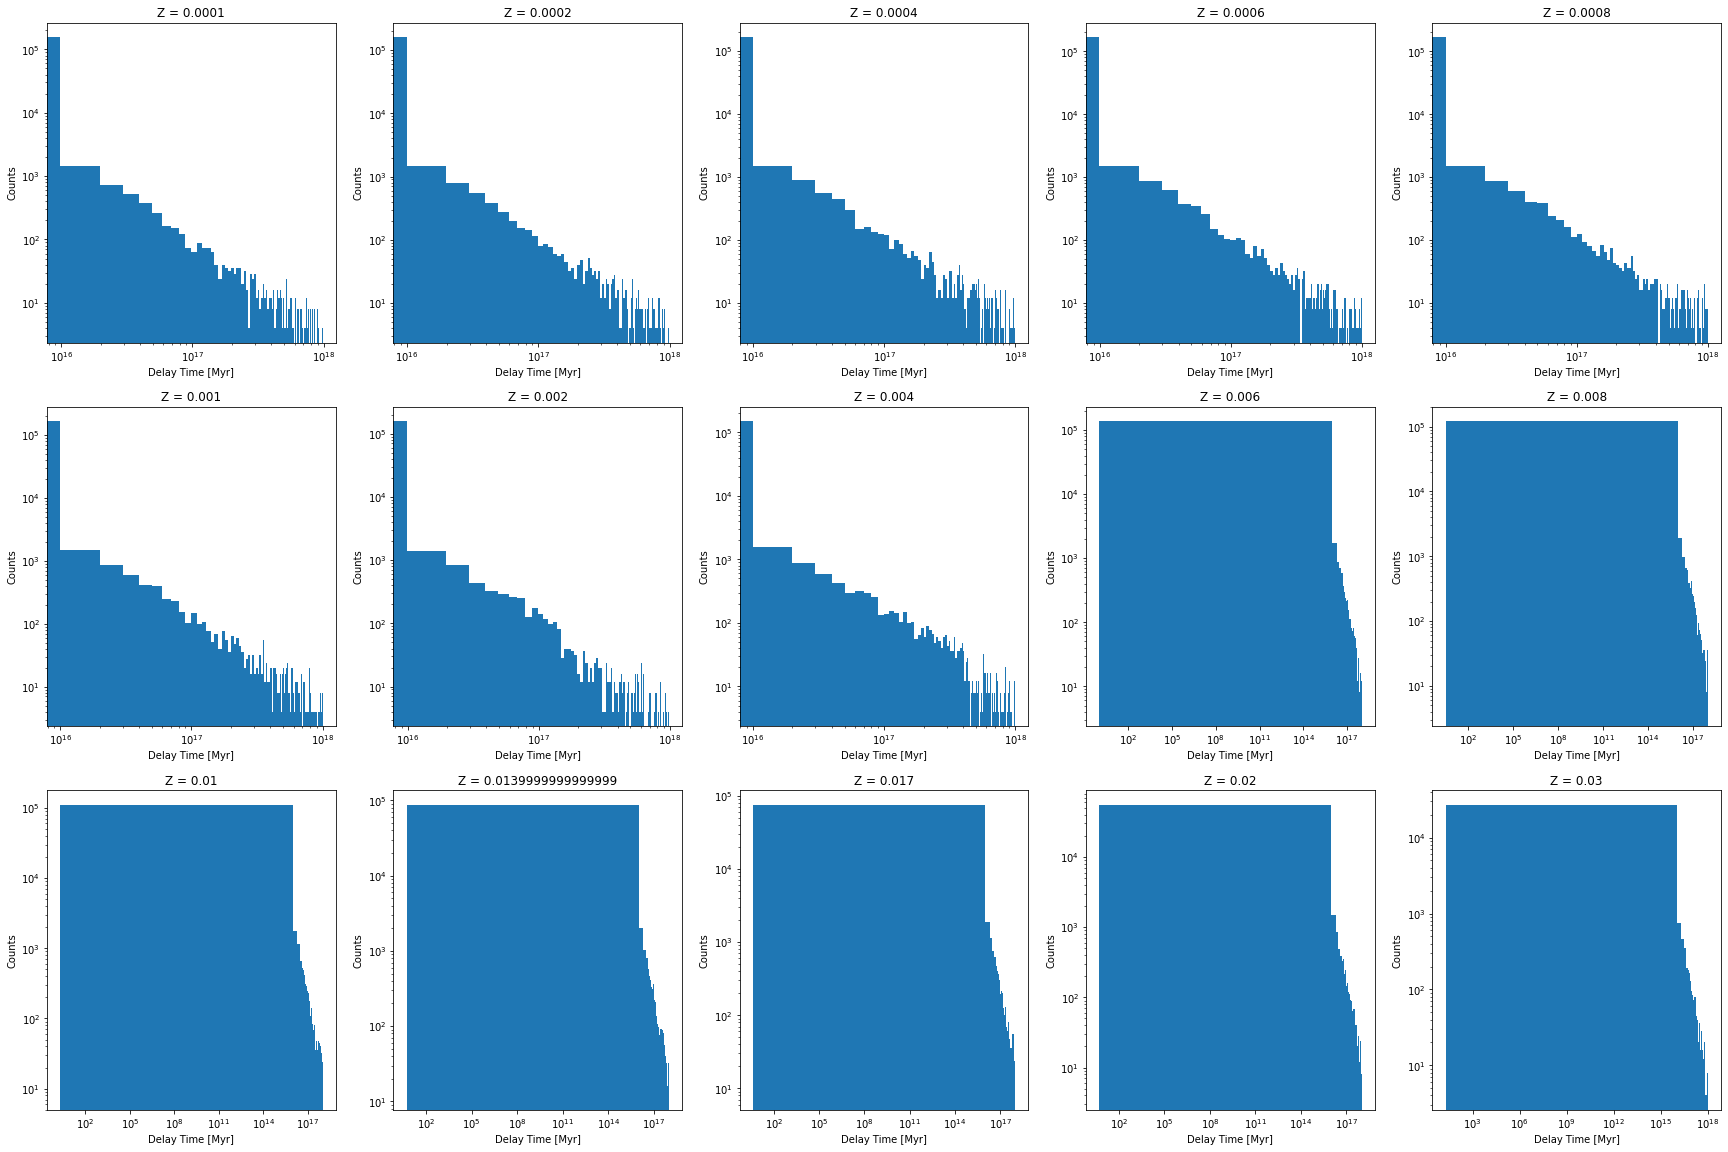

In [84]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].hist(Z_df[key][(Z_df[key].Delay_Time<1e18)].Delay_Time, bins=50)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

Distribution tabulated delay time for different values of Z.

<function matplotlib.pyplot.show(close=None, block=None)>

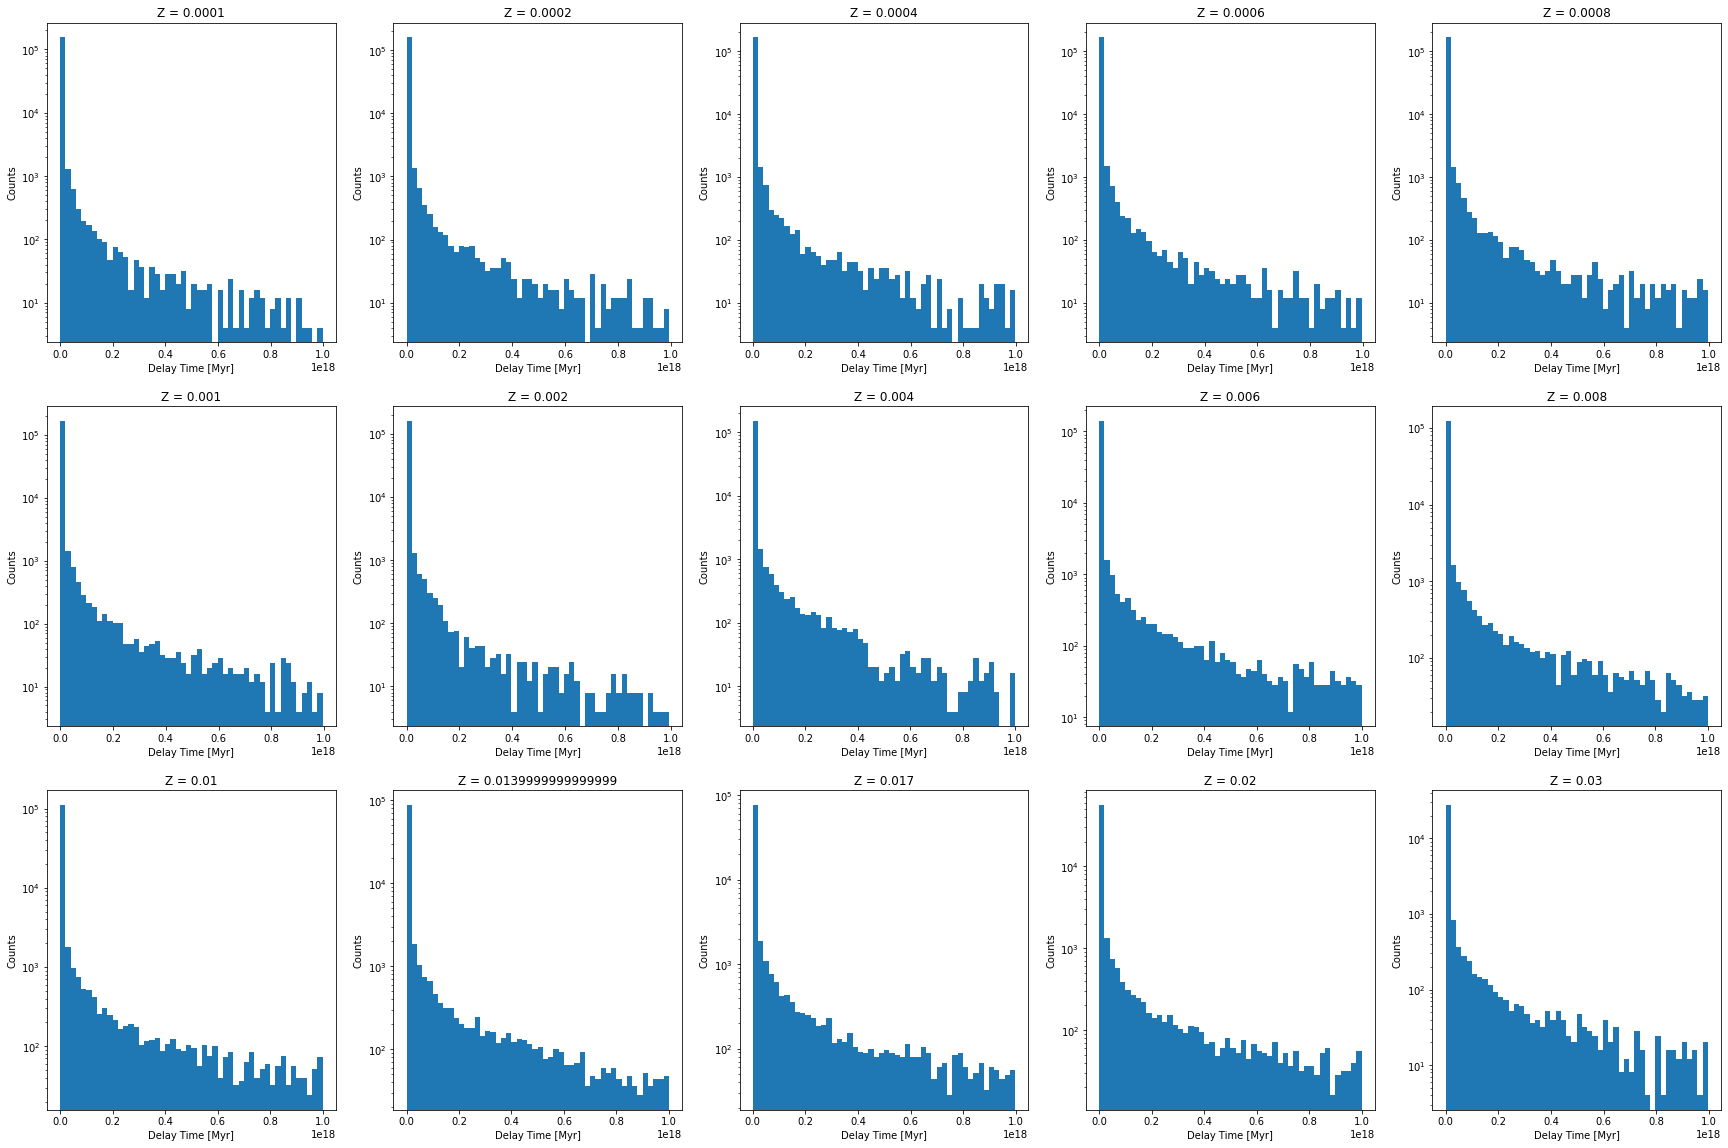

In [85]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].hist(Z_df[key][(Z_df[key].GWtime<1e18)].GWtime, bins=50)
    #ax[x,y].hist(Z_df[key].GWtime+Z_df[key].BWorldtime)
    #ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

Distribution computed delay time for different values of alpha

<function matplotlib.pyplot.show(close=None, block=None)>

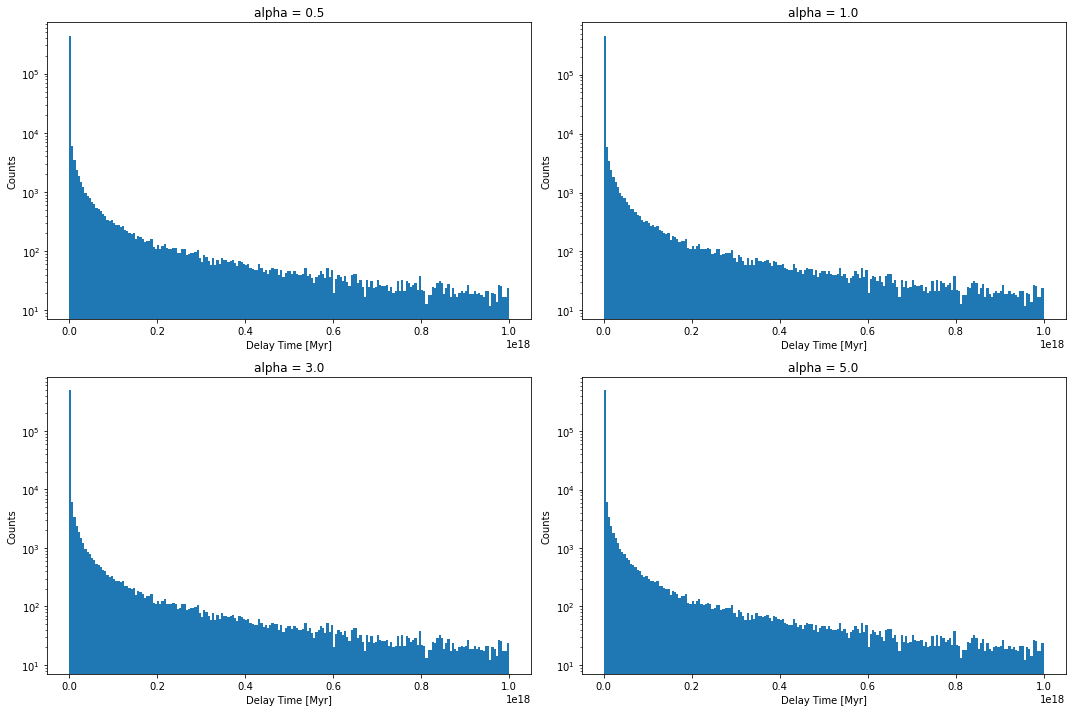

In [88]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    ax[x,y].hist(alpha_df[key][(alpha_df[key].Delay_Time<1e18)].Delay_Time, bins=200)
    #ax[x,y].hist(alpha_df[key].Delay_Time)
    #ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('alpha = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 2:
        x +=1
        y = 0

fig.tight_layout()
plt.show

Distribution tabulated delay time for different values of alpha

<function matplotlib.pyplot.show(close=None, block=None)>

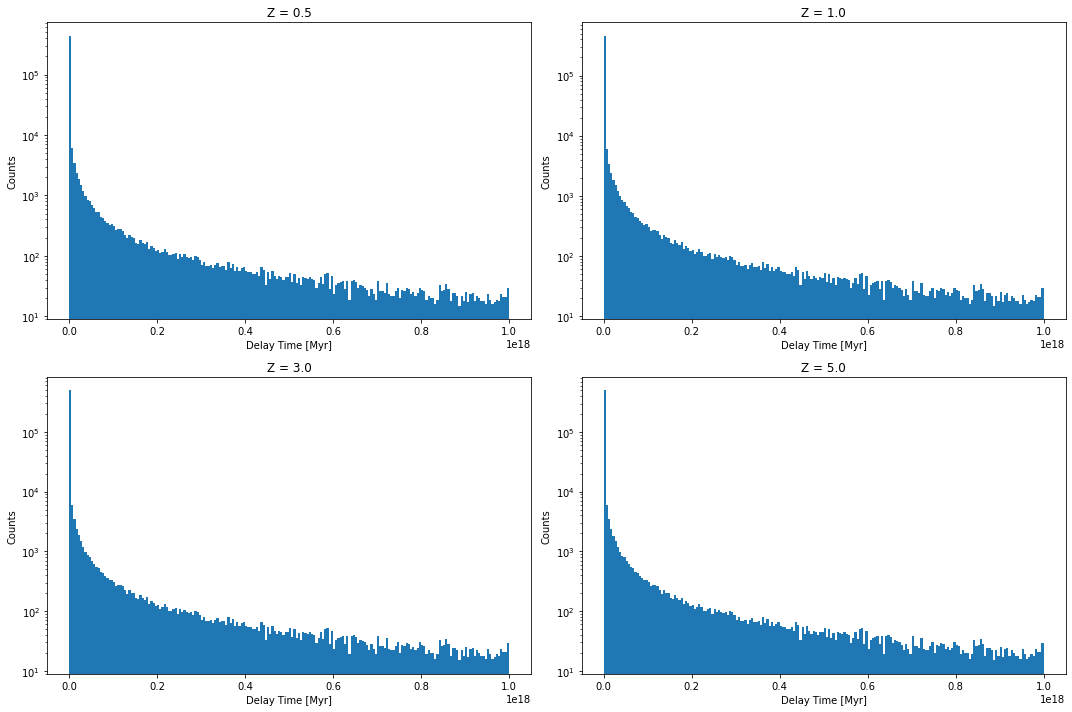

In [89]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    ax[x,y].hist(alpha_df[key][(alpha_df[key].GWtime<1e18)].GWtime, bins=200)
    #ax[x,y].hist(alpha_df[key].GWtime+alpha_df[key].BWorldtime)
    #ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 2:
        x +=1
        y = 0

fig.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

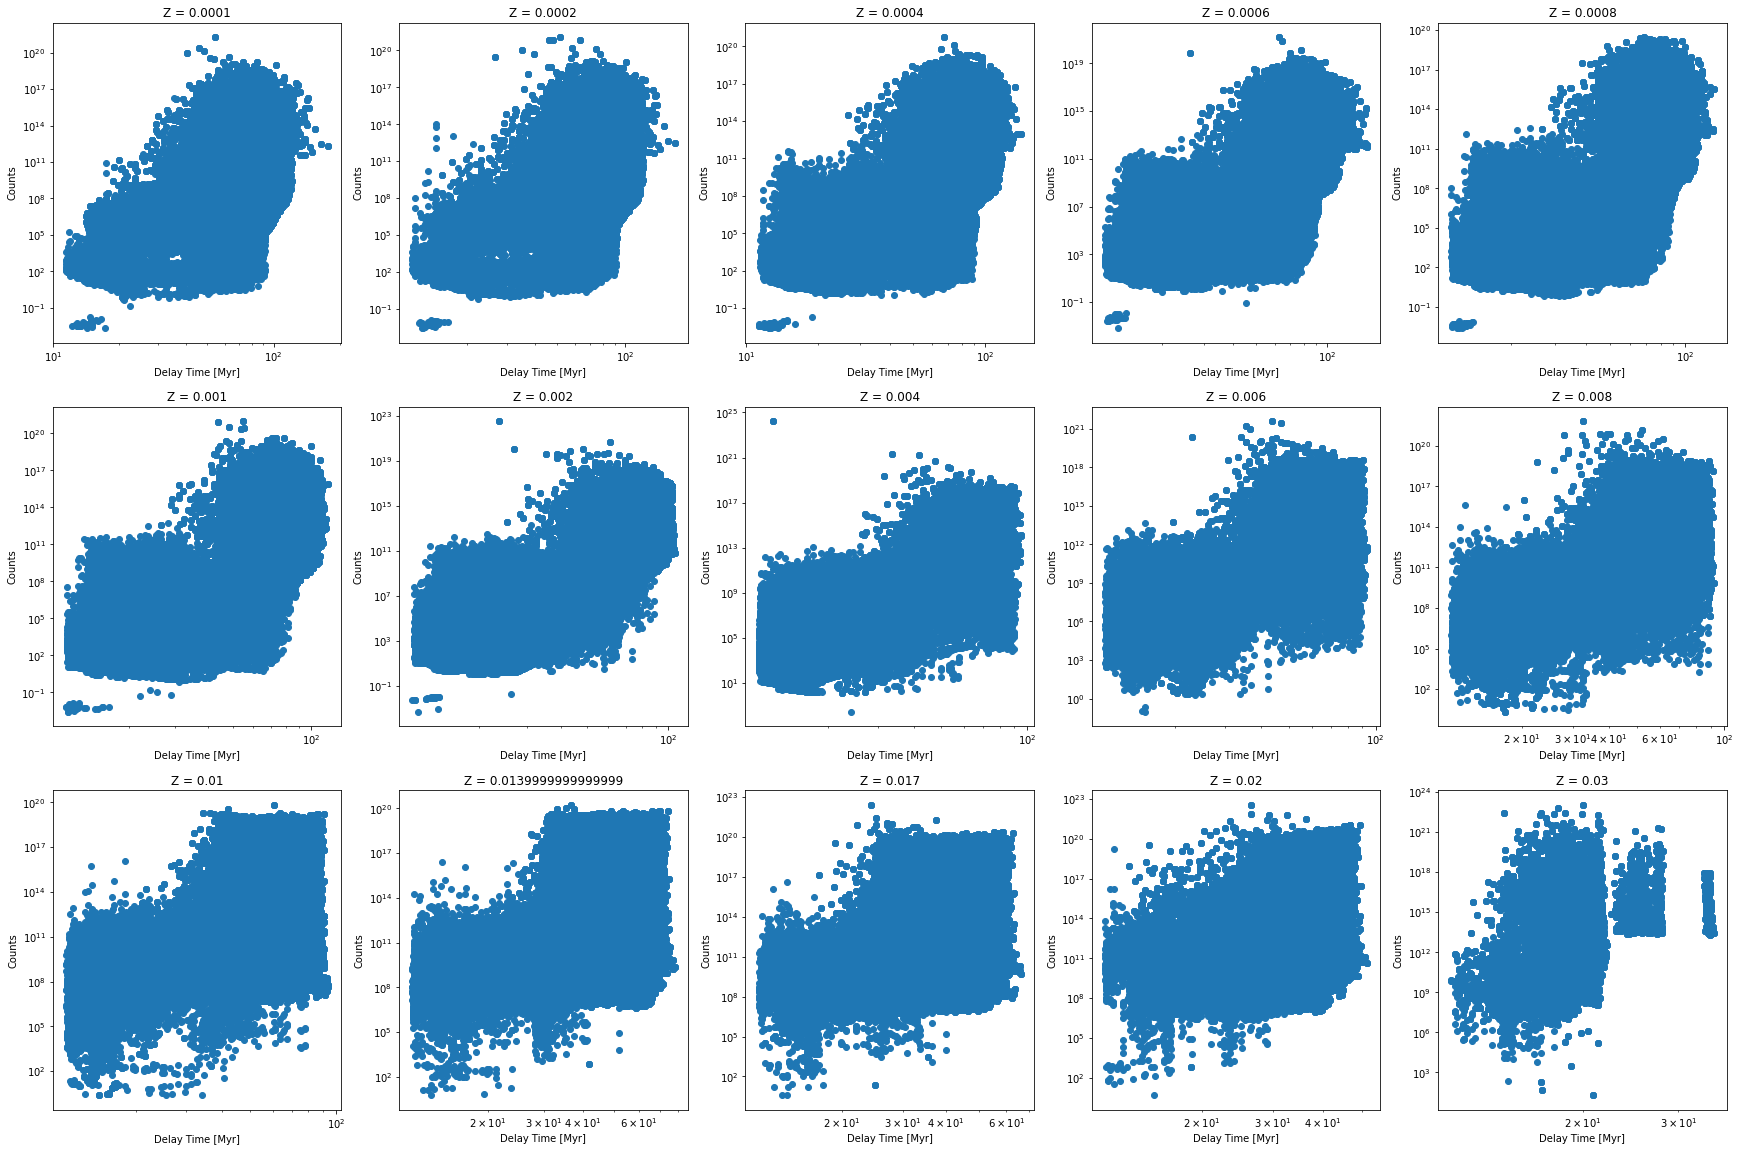

In [11]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(Z_df[key].Mass_0+Z_df[key].Mass_1, Z_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_ylabel('Delay Time [Myr]')
    ax[x,y].set_xlabel('Total Mass')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

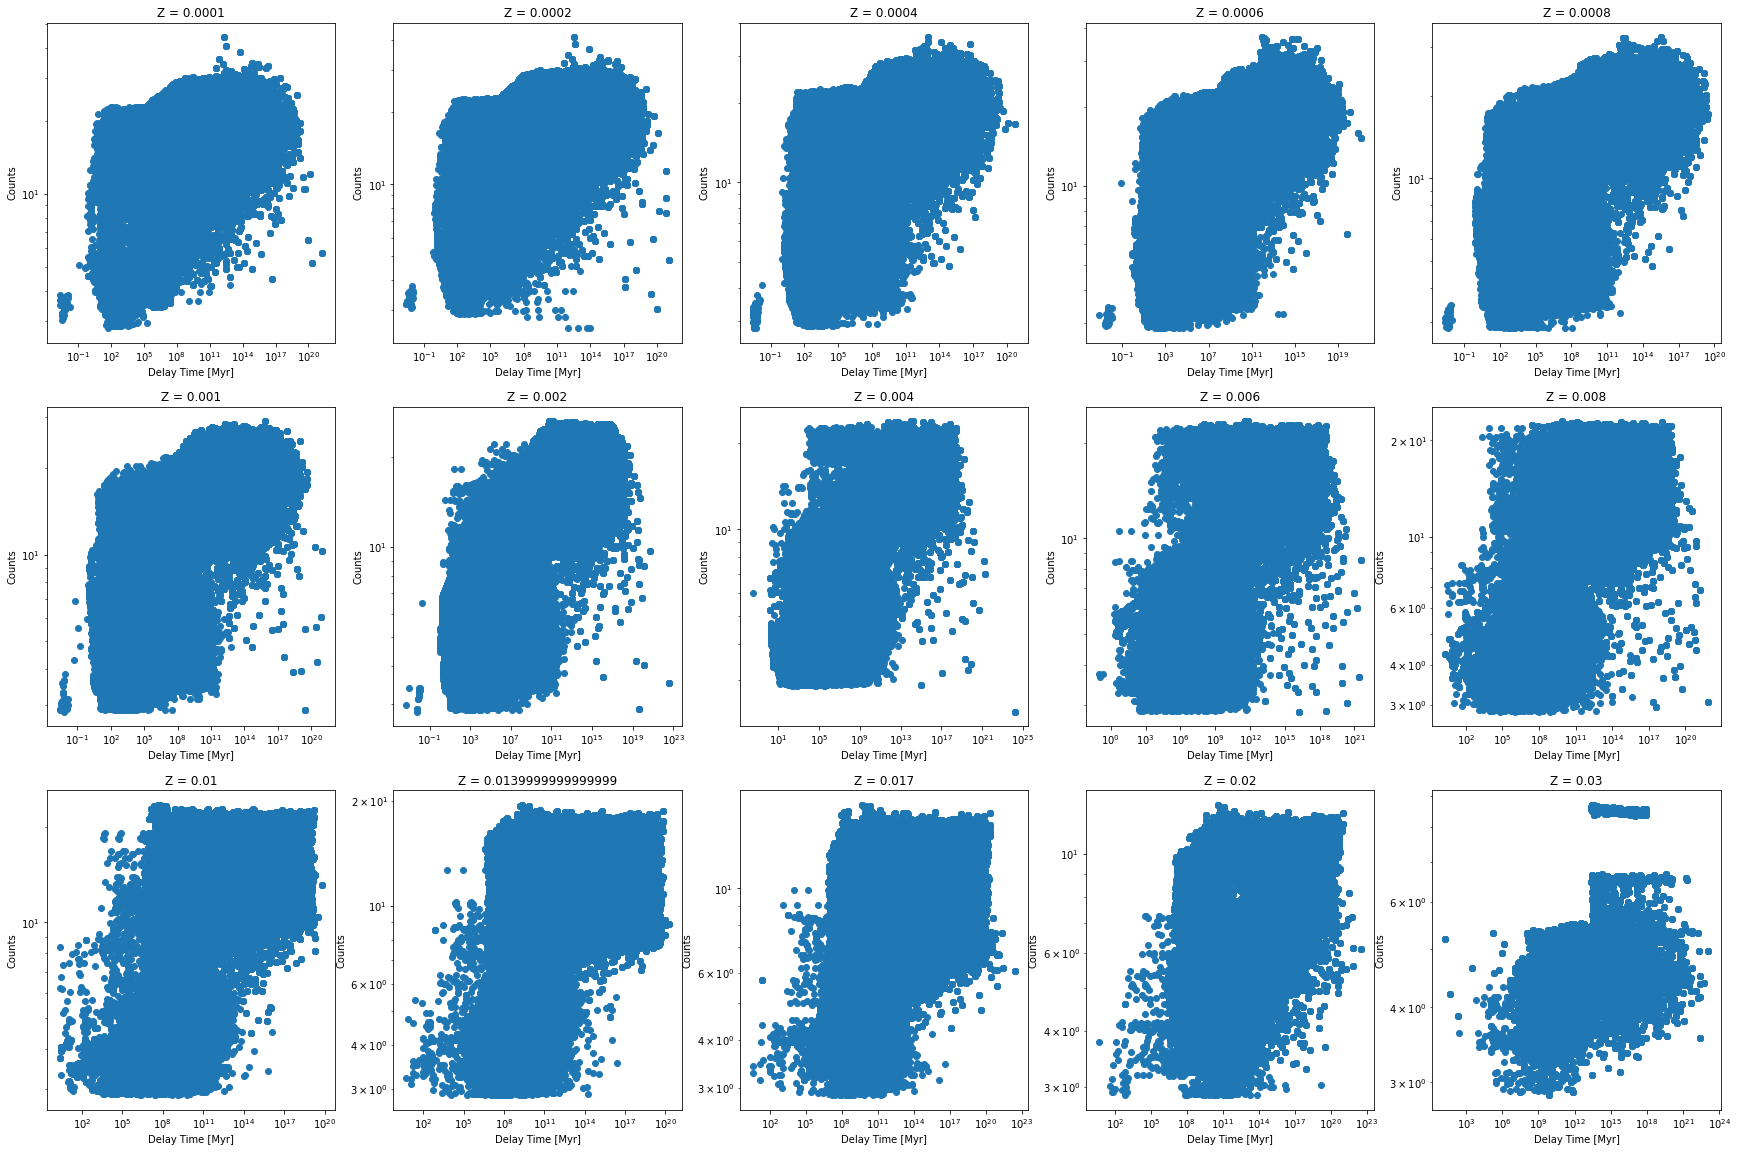

In [18]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(Z_df[key].Mass_reduced, Z_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_ylabel('Delay Time [Myr]')
    ax[x,y].set_xlabel('Reduced Mass')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

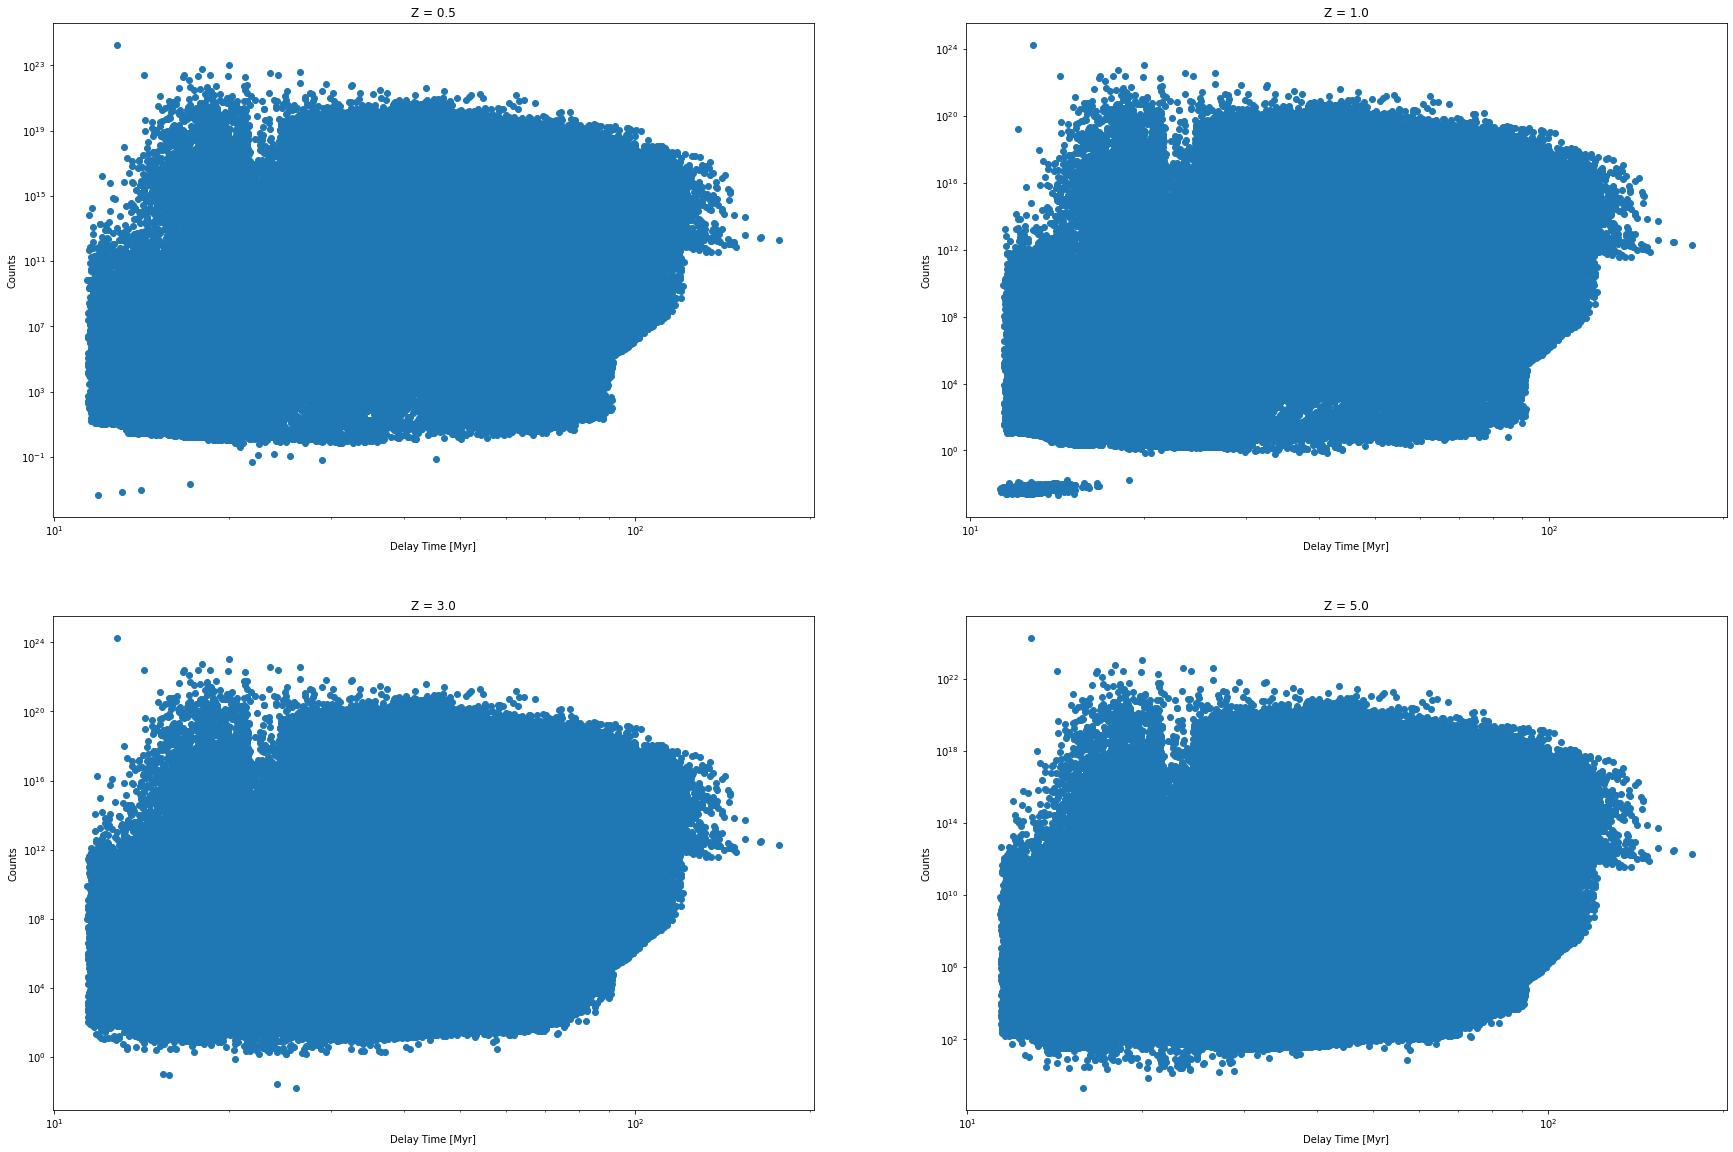

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    ax[x,y].scatter(alpha_df[key].Mass_0+alpha_df[key].Mass_1, alpha_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_ylabel('Delay Time [Myr]')
    ax[x,y].set_xlabel('Total Mass')

    y += 1
    if y == 2:
        x +=1
        y = 0

plt.show